In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import gzip
from pybedtools import BedTool
import os
from tqdm import tqdm
import sys
sys.path.append('/project2/mstephens/cfbuenabadn/gtex-stm/code')
sys.path.append('/project2/mstephens/cfbuenabadn/gtex-stm/code/scripts')
from get_unique_region_counts import *
from sNMF_plots import *
from get_isoforms import *
from get_unique_region_counts import *
from plot_factors import *


import rpy2
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import rpy2.robjects.packages as rpackages


def load_ebpmf_gene(gene_id):
    readRDS = ro.r['readRDS']
    df = readRDS(f'/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/RDS/{gene_id}.rds')
    with (ro.default_converter + pandas2ri.converter).context():
        pd_from_r_df = ro.conversion.get_conversion().rpy2py(df)

    output = pd_from_r_df

    return output

colores = np.array(sns.color_palette("tab10"))


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


loading modules
some more modules
custom-made modules
finished loading modules


In [2]:
def plot_factors_wrapper(rds, gene, ebpmf='ebpmf_10', strand='plus', colores=None, figsize=None, lm=True, factor_list = None, 
                         ax = None, xlim=None, plot_coords = False, lwidth=3, mute_y_axis = False):
    EF = pd.DataFrame(rds[ebpmf]['train_fit']['EF_smooth'][1:-1,:])
    EF.index = rds[ebpmf]['coords']

    if xlim is None:
        
        xlim1 = int(rds[ebpmf]['coords'][0].split(':')[1])-1000
        xlim2 = int(rds[ebpmf]['coords'][-1].split(':')[1])+1000
        xlim = (xlim1, xlim2)

    # xlim = (xlim1, xlim2)
    # print(xlim1, xlim2)
    
    EF.columns = [f'factor{str(i+1)}' for i in range(EF.shape[1])]

    if factor_list is not None:
        EF = EF[factor_list]
        EF = pd.DataFrame(EF)
        K = EF.shape[1]
        EF.columns = [f'factor{str(i)}' for i in range(1, K+1)]
    
    for factor in EF.columns:
        
        if lm:
            y = factor_lm(EF[factor], strand)
        else:
            y = np.array(EF[factor])
        EF[factor] = y
    plot_factor_tracks(EF/EF.quantile(0.99, axis=0), gene, EF.shape[1], colores = colores, figsize=figsize, ax=ax, 
                       xlim=xlim, plot_coords = plot_coords, mute_y_axis=mute_y_axis)


def plot_factor_tracks(EF, gene, K, title=None, fill=True, smooth=False, colores = None, q=0.99, figsize=None, ax=None, xlim=None, 
                       plot_coords=None, lwidth=None, mute_y_axis=False):

    EF = np.minimum(EF/EF.quantile(q, axis=0), 1)

    if colores is None:
        if K <= 5:
            colores = ['tab:blue', 'tab:orange', 'tab:green', 'goldenrod', 'tab:red'] 
        else:
            colores = sns.color_palette("tab10")
    
    if K <= 3:
        S = K
    else:
        S = K*0.8

    if figsize is None:
        figsize=(15, S)

    if ax is None:
        fig, ax = plt.subplots(nrows = K, figsize=figsize, gridspec_kw={'height_ratios': [2]*K, 
                                                                               'wspace': 0.3, 'hspace': 0.3})

    start = int(EF.index[0].split(':')[1])
    end = int(EF.index[-1].split(':')[1])
    length = EF.shape[0]
    
    coords = np.linspace(start, end, num=length)
    
    for i in range(K):
        factor = f'factor{i+1}'
        scaled_y = EF[factor]#/np.max(EF[factor])
        if fill:
            ax[i].fill_between(coords, np.zeros(len(coords)), scaled_y, color=colores[i], alpha=0.3)
#         else:
        ax[i].plot(coords, scaled_y, c=colores[i], alpha=0.9, linewidth=lwidth)
        
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        if (i < K-1) or (not plot_coords):
            ax[i].set_xticks([])
            ax[i].spines['bottom'].set_visible(False)

        if mute_y_axis:
            ax[i].spines['left'].set_visible(False)
            ax[i].set_yticks([])

        ax[i].set_xlim([xlim[0], xlim[1]])
        
        #ax[i].text(start+((end-start)*1.1), 0.9, factor, size=12)

    
        
    if title:
        fig.suptitle(title, fontsize=12, x=0.5, y=1.1)

    


###############

def plot_isoform_annotations(annotation_exons, gene, colores=None, start=None, end=None, figsize=None, lwidth=5, iso_order=None, axes=None, xlim=None):

    gene_exons = annotation_exons.loc[annotation_exons.gene_id == gene]

    if iso_order is None:
        isoforms = sorted(gene_exons.transcript_id.unique())
    else:
        isoforms = [gene + '.' + x for x in iso_order]

    isoform_dict = {}
    for i, iso in enumerate(isoforms):
        isoform_name = f'isoform_{str(i+1)}'
        df = gene_exons.loc[gene_exons.transcript_id == iso].copy()
        df['transcript_id'] =  f'{gene}.{isoform_name}'
        isoform_dict.update({isoform_name:{'df':df}})

    chrom = list(annotation_exons.chrom)[0]
    if start is None:
        start = str(np.min([int(list(gene_exons.start)[0]), int(list(gene_exons.start)[0])]) - 1000)
    if end is None:
        end = str(np.max([int(list(gene_exons.end)[-1]), int(list(gene_exons.end)[-1])]) + 1000)

    coords = [f'{chrom}:{start}', f'{chrom}:{end}']

    # print(isoform_dict)

    plot_gene_isoforms(isoform_dict, coords, color_list = colores, figsize=figsize, lwidth=lwidth, axes=axes, xlim=xlim)


def plot_gene_isoforms(isoforms_dict, coordinates, color_list = None, axes=None, figsize=None, lwidth=5, xlim=None):

    if xlim is None:
        xlim1 = int(coordinates[0].split(':')[1])
        xlim2 = int(coordinates[-1].split(':')[1])
    else:
        xlim1 = xlim[0]
        xlim2 = xlim[1]
    

    if color_list is None:
        color_list = sns.color_palette("tab10")

    K = len(isoforms_dict)

    if figsize is None:
        figsize=(20, 3)

    if axes is None:
        fig, axes = plt.subplots(K, 1, figsize=figsize)

    for i in range(K):
        isoform_df = isoforms_dict[f'isoform_{str(i+1)}']['df']
        # print(isoform_df)
        ax = axes[i]
        color = color_list[i]
        plot_isoform(isoform_df, ax, color, xlim[0], xlim[1], lwidth=lwidth)


def plot_isoform(isoform_df, ax, color, xlim1, xlim2, lwidth):
    # print(isoform_df)
    is_first = True
    for idx, row in isoform_df.iterrows():
        start = int(row.start)
        end = int(row.end)
        if is_first:
            first = end
            is_first = False
    
        ax.fill_between([start, end], [0, 0], [1, 1], color = color, zorder=2)
    
    ax.plot([first, start], [0.5, 0.5], c=color, linewidth=lwidth)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[['bottom', 'top', 'right', 'left']].set_visible(False)
    ax.set_xlim([xlim1, xlim2])

    # print(xlim1, xlim2)


def plot_barh_ax(loadings, color, ax, label='label', sort_factor = False):
    x = range(len(loadings))
    if sort_factor:
        loadings = sorted(loadings) 
    ax.barh(x, loadings, width=4, color=color, alpha=0.7)
    if sort_factor:
        median = np.median(loadings)
        middle_point = len(loadings)/2
        ax.plot([0, len(loadings)], [median, median], linestyle = '--', c='black', linewidth=2)
        ax.scatter([middle_point], [median], marker="D", c = 'black', s=10)
    
    
    
def factor_barplot_h(EL, samples, color_list, label_list, sort_factor = False, figsize=None, ylim = None, one_row = False, 
                   tissue_colors = None, print_labels=False):
    samples = samples.loc[EL.index]
    tissues = samples.tissue_id.unique()
    factors = EL.columns
    
    K = len(factors)
    N = len(tissues)

    if figsize is None:
        figsize = (N/3,K/1.2)
    
    
    

    if one_row:
        fig, axes = plt.subplots(N+1,2, figsize=figsize, gridspec_kw={'wspace': 0.05, 'hspace': 0.1}, 
                             height_ratios = (([4]*N) + [1]), width_ratios = [1.2, 10])

        for j, tissue in enumerate(tissues):
            label = label_list[j]
            tissue_samples = samples.loc[samples.tissue_id == tissue].index


            EL_sorted = EL.loc[tissue_samples].sort_values(factors[0])
            
            #loadings = list(EL.loc[tissue_samples, factors[0]])

            ax = axes[j, 1]

            ax_ = axes[j, 0]
            ax_.barh([1], [1], color = tissue_colors[j])

            ax_.axis('off')  # Hide
            ax_.margins(0, 0)
            ax_.spines['top'].set_visible(False)
            ax_.spines['bottom'].set_visible(False)
            ax_.spines['right'].set_visible(False)
            ax_.spines['left'].set_visible(False)
            ax_.set_xticks([])
            ax_.set_yticks([])

            if j == 0:

                ax_ = axes[0, 1]
    
                ax_.axis('off')  # Hide
                ax_.margins(0, 0)
                ax_.spines['top'].set_visible(False)
                ax_.spines['bottom'].set_visible(False)
                ax_.spines['right'].set_visible(False)
                ax_.spines['left'].set_visible(False)
                ax_.set_xticks([])
                ax_.set_yticks([])

            loadings = np.array(EL_sorted[factors[0]])

            median = np.median(loadings)
            middle_point = len(loadings)/2
            for i, loading in enumerate(loadings):
                ax.plot([0, loading], [i, i], c=color_list[0])

                cum_sum = loading
                for j in range(1, len(factors)):
                    loading_ = EL_sorted.iloc[i,j]
                    if j == (len(factors)-1):
                        top_bar = 1
                    else:
                        top_bar = cum_sum + loading_
                    ax.plot([cum_sum, top_bar], [i, i], c=color_list[j])
                    cum_sum += loading_
                
                # ax.plot([i, i], [loading, 1], c=color_list[1])
                
            ax.plot([median, median], [len(loadings), 0], linestyle = '--', c='black', linewidth=2)
            ax.scatter([median], [middle_point], marker="D", c = 'black', s=10, zorder=len(loadings)+2)

            axes[N, 1].spines['top'].set_visible(False)
            axes[N, 1].spines['right'].set_visible(False)
            axes[N, 1].spines['left'].set_visible(False)
            axes[N, 1].set_yticks([])
            axes[N,1].tick_params(labelsize=10)
            if print_labels:
                ax.set_xlabel(label, rotation=45)

            if ylim is None:
                axes[N, 0].set_xlim([0,1])

                ax.set_xlim([0,1])
            else:
                axes[N, 0].set_xlim(ylim)
                ax.set_ylim(ylim)
            ax.spines['top'].set_visible(False)
            
            ax.spines['left'].set_visible(False)
            ax.set_yticks([])
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])

            ax_ = axes[N, 0]
    
            ax_.axis('off')  # Hide
            ax_.margins(0, 0)
            ax_.spines['top'].set_visible(False)
            ax_.spines['bottom'].set_visible(False)
            ax_.spines['right'].set_visible(False)
            ax_.spines['left'].set_visible(False)
            ax_.set_xticks([])
            ax_.set_yticks([])
            
            # ax[0].set_ylabel(factor)
            #plot_bar_ax(loadings, color, ax, label=label, sort_factor=True)

    # axes

    else:
        fig, axes = plt.subplots(K,N+1, figsize=figsize, gridspec_kw={'wspace': 0.1, 'hspace': 0.1}, 
                             width_ratios = ([1]+([4]*N)))
    
        for i, factor in enumerate(factors):
            color = color_list[i]
            
            axes[i,0].spines['top'].set_visible(False)
            axes[i,0].spines['right'].set_visible(False)
            axes[i,0].spines['bottom'].set_visible(False)
            axes[i,0].set_xticks([])
            axes[i,0].set_ylabel(factor)
            
            factor_max = EL[factor].max()
            
            axes[i,0].set_ylim([0,factor_max])
            
            for j, tissue in enumerate(tissues):
                if i == (len(factors)-1):
                    label = label_list[j]
                else:
                    label = ''
                tissue_samples = samples.loc[samples.tissue_id == tissue].index
                loadings = list(EL.loc[tissue_samples, factor])
                
                    
                ax = axes[i,j+1]
                plot_barh_ax(loadings, color, ax, label=label, sort_factor=sort_factor)
                
                ax.set_ylim([0,factor_max])
                ax.spines['top'].set_visible(False)
                
                ax.spines['left'].set_visible(False)
                ax.set_yticks([])
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.set_xticks([])
                
    
            #     ax.axis('off')  # Hide
                ax.margins(0, 0)
                
    
                ax.set_xlabel(label, rotation=45)



def plot_bar_ax(loadings, color, ax, label='label', sort_factor = False):
    x = range(len(loadings))
    if sort_factor:
        loadings = sorted(loadings) 
    ax.bar(x, loadings, width=4, color=color, alpha=0.7)
    if sort_factor:
        median = np.median(loadings)
        middle_point = len(loadings)/2
        ax.plot([0, len(loadings)], [median, median], linestyle = '--', c='black', linewidth=2)
        ax.scatter([middle_point], [median], marker="D", c = 'black', s=10)
    
    
    
def factor_barplot(EL, samples, color_list, label_list, tissue_colors, sort_factor = False):
    samples = samples.loc[EL.index]
    tissues = samples.tissue_id.unique()
    factors = EL.columns
    
    K = len(factors)
    N = len(tissues)
    
    
    fig, axes = plt.subplots(K+1,N+1, figsize=(N/3,K/1.5), gridspec_kw={'wspace': 0.1, 'hspace': 0.2}, 
                             width_ratios = ([1]+([4]*N)), height_ratios=[1]*K + [0.25])
    
    for i, factor in enumerate(factors):
        color = color_list[i]
        
        axes[i,0].spines['top'].set_visible(False)
        axes[i,0].spines['right'].set_visible(False)
        axes[i,0].spines['bottom'].set_visible(False)
        axes[i,0].set_xticks([])
        # axes[i,0].set_ylabel(factor)
        
        factor_max = EL[factor].max()
        
        axes[i,0].set_ylim([0,factor_max])
        
        for j, tissue in enumerate(tissues):
            if i == (len(factors)-1):
                label = label_list[j]
            else:
                label = ''
            tissue_samples = samples.loc[samples.tissue_id == tissue].index
            loadings = list(EL.loc[tissue_samples, factor])
            
                
            ax = axes[i,j+1]
            plot_bar_ax(loadings, color, ax, label=label, sort_factor=sort_factor)
            
            ax.set_ylim([0,factor_max])
            ax.spines['top'].set_visible(False)
            
            ax.spines['left'].set_visible(False)
            ax.set_yticks([])
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])
            

        #     ax.axis('off')  # Hide
            ax.margins(0, 0)
            

            # ax.set_xlabel(label, rotation=45)


            ax_ = axes[K, j+1]
            ax_.barh([1], [1], color = tissue_colors[j])
    
            ax_.axis('off')  # Hide
            ax_.margins(0, 0)
            ax_.spines['top'].set_visible(False)
            ax_.spines['bottom'].set_visible(False)
            ax_.spines['right'].set_visible(False)
            ax_.spines['left'].set_visible(False)
            ax_.set_xticks([])
            ax_.set_yticks([])

    
            axes[K, 0].axis('off')  # Hide
            axes[K, 0].margins(0, 0)


In [3]:
gencode_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/Annotations/gencode.v44.primary_assembly.exons.sorted.bed.gz'
gencode_exons = pd.read_csv(gencode_exons_bed, sep='\t')

snmf_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/snmf_10/tables/snmf.merged_isoforms.exons.sorted.bed.gz'
snmf_exons = pd.read_csv(snmf_exons_bed, sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 
                                                 'transcript_id', 'strand', 'factors', 'exon_id'])


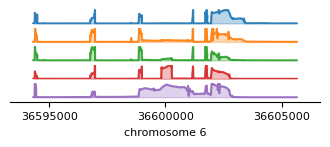

In [26]:
rds = load_ebpmf_gene('ENSG00000112081')
colores = sns.color_palette("tab10", 10)

fig, ax = plt.subplots(nrows = 6, figsize=(4, 1.2), gridspec_kw={'height_ratios': [1.5]*5 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.3})

xlim1 = int(rds['ebpmf_5']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_5']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)


plot_factors_wrapper(rds, 'ENSG00000112081', 'ebpmf_5', colores=colores, ax=ax[:5], xlim=xlim, lwidth=1, mute_y_axis=True, lm=True,
                    factor_list = ['factor1', 'factor3', 'factor4', 'factor2', 'factor5'])

ax[5].spines['top'].set_visible(False)
ax[5].spines['right'].set_visible(False)
ax[5].spines['left'].set_visible(False)
ax[5].set_yticks([])
ax[5].set_xlim(xlim)
ax[5].set_xticks([36595000, 36600000, 36605000])
ax[5].set_xticklabels(['36595000', '36600000', '36605000'])
ax[5].tick_params(labelsize=8)
ax[5].set_xlabel('chromosome 6', fontsize=8)

plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.png', bbox_inches='tight', dpi=500)

In [27]:
snmf_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/snmf_5/tables/snmf.3prime_corrected.exons.sorted.bed.gz'
snmf_exons = pd.read_csv(snmf_exons_bed, sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 
                                                 'transcript_id', 'strand', 'factors', 'exon_id'])


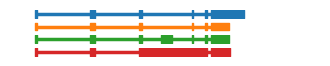

In [28]:
fig, ax = plt.subplots(nrows = 4, figsize=(4, .6), gridspec_kw={'height_ratios': [1.5]*4, 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_5']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_5']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000112081', colores = colores,
                         axes=ax, xlim=xlim, lwidth=2.5, iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

In [29]:
EL = pd.read_csv('../code/ebpmf_models/filtered/snmf_5/tables/EL.bed.gz', sep='\t', index_col=3)
transcript_EL = pd.read_csv('../code/ebpmf_models/filtered/snmf_5/tables/transcript.3prime_corrected.EL.bed.gz', sep='\t', index_col=3)
samples = pd.read_csv('../code/config/samples.tsv', sep='\t', index_col=0)


In [30]:
tissues = sorted(['Brain_Anterior_cingulate_cortex_BA24',
 'Brain_Cortex',
 'Brain_Frontal_Cortex_BA9',
 'Brain_Putamen_basal_ganglia',
           'Skin_Not_Sun_Exposed_Suprapubic',
           'Liver',
 'Lung', 'Heart_Atrial_Appendage', 'Muscle_Skeletal','Whole_Blood'
          ])

sorted_samples = []
for t in tissues:
    sorted_samples.extend(list(transcript_EL.columns.intersection(samples.loc[samples.tissue_id == t].index)))

colors_list = ['goldenrod', 'gold', 'yellow', 'khaki', 'darkviolet', 'tab:green', 'mediumblue', 
            'lightsalmon', 'turquoise', 'tab:red']

tissue_list_names = ['Brain Anterior cingulate cortex BA24',
 'Brain Cortex',
 'Brain Frontal Cortex BA9',
 'Brain Putamen basal ganglia',
 'Heart Atrial Appendage',
 'Liver',
 'Lung',
 'Muscle Skeletal',
 'Skin Not Sun Exposed Suprapubic',
 'Whole Blood']

sample_slice = samples.loc[sorted_samples]

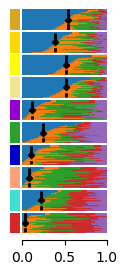

In [31]:
EL_to_plot = EL.loc[EL.gid == 'ENSG00000112081', sorted_samples].T 
# transcripts_to_plot
factor_order = [f'ENSG00000112081.{factor}' for factor in ['factor_1', 'factor_3', 'factor_4', 'factor_2', 'factor_5']]
EL_to_plot = EL_to_plot[factor_order]
EL_to_plot.columns = [f'ENSG00000112081.factor_{str(i)}' for i in range(1, 6)]

colors_list = ['goldenrod', 'gold', 'yellow', 'khaki', 'darkviolet', 'tab:green', 'mediumblue', 
            'lightsalmon', 'turquoise', 'tab:red']

colores = sns.color_palette("tab10")
# colores = [colores[0], colores[1], colores[3], colores[4], colores[5]]
factor_barplot_h(EL_to_plot, samples, colores,
              ['BA24', 'BC', 'BA9', 'BP', 'HRT', 'LIV', 'LUN', 'MS', 'SKN', 'WB'], sort_factor=True, one_row=True, figsize=(1.25, 3),
              tissue_colors = colors_list)

plt.savefig('../code/scratch_figures/figure1/SRSF3.hloadings_5.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/SRSF3.hloadings_5.png', bbox_inches='tight', dpi=500)

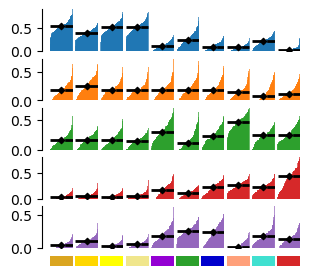

In [32]:
factor_barplot(EL_to_plot, samples, colores,
              ['BA24', 'BC', 'BA9', 'BP', 'HRT', 'LIV', 'LUN', 'MS', 'SKN', 'WB'], 
               tissue_colors = colors_list,
               sort_factor=True)

plt.savefig('../code/scratch_figures/figure1/SRSF3.loadings_5.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/SRSF3.loadings_5.png', bbox_inches='tight', dpi=500)

In [33]:
transcripts_to_plot = transcript_EL.loc[transcript_EL.gid == 'ENSG00000112081', sorted_samples].T 
# transcripts_to_plot
iso_order=[f'ENSG00000112081.{iso}' for iso in ['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4']]
transcripts_to_plot = transcripts_to_plot[iso_order]
transcripts_to_plot.columns = [f'ENSG00000112081.isoform_{str(i)}' for i in range(1, 5)]

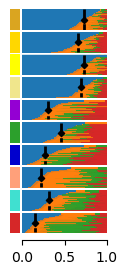

In [34]:
colors_list = ['goldenrod', 'gold', 'yellow', 'khaki', 'darkviolet', 'tab:green', 'mediumblue', 
            'lightsalmon', 'turquoise', 'tab:red']

colores = sns.color_palette("tab10")
# colores = [colores[0], colores[1], colores[3], colores[4], colores[5]]
factor_barplot_h(transcripts_to_plot, samples, colores,
              ['BA24', 'BC', 'BA9', 'BP', 'HRT', 'LIV', 'LUN', 'MS', 'SKN', 'WB'], sort_factor=True, one_row=True, figsize=(1.25, 3),
              tissue_colors = colors_list)

plt.savefig('../code/scratch_figures/figure1/SRSF3.hloadings_transcripts_5.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/SRSF3.hloadings_transcripts_5.png', bbox_inches='tight', dpi=500)

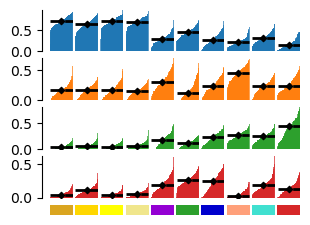

In [35]:
factor_barplot(transcripts_to_plot, samples, colores,
              ['BA24', 'BC', 'BA9', 'BP', 'HRT', 'LIV', 'LUN', 'MS', 'SKN', 'WB'], 
               tissue_colors = colors_list,
               sort_factor=True)

plt.savefig('../code/scratch_figures/figure1/SRSF3.loadings_transcripts_5.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/SRSF3.loadings_transcripts_5.png', bbox_inches='tight', dpi=500)

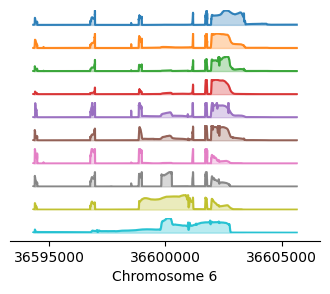

In [36]:
rds = load_ebpmf_gene('ENSG00000112081')
colores = sns.color_palette("tab10", 10)

fig, ax = plt.subplots(nrows = 11, figsize=(4, 3), gridspec_kw={'height_ratios': [1.5]*10 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)


plot_factors_wrapper(rds, 'ENSG00000112081', 'ebpmf_10', colores=colores, ax=ax[:10], xlim=xlim, lwidth=1, mute_y_axis=True, lm=False,
                    factor_list = ['factor1', 'factor6', 'factor7', 'factor10', 'factor3', 'factor5',  'factor4', 
                                   'factor9', 'factor8', 'factor2'])

ax[10].spines['top'].set_visible(False)
ax[10].spines['right'].set_visible(False)
ax[10].spines['left'].set_visible(False)
ax[10].set_yticks([])
ax[10].set_xlim(xlim)
ax[10].set_xticks([36595000, 36600000, 36605000])
ax[10].set_xticklabels(['36595000', '36600000', '36605000'])
ax[10].tick_params(labelsize=10)
ax[10].set_xlabel('Chromosome 6', fontsize=10)

plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_10.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_10.png', bbox_inches='tight', dpi=500)

In [38]:
snmf_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/snmf_10/tables/snmf.merged_isoforms.exons.sorted.bed.gz'
snmf_exons = pd.read_csv(snmf_exons_bed, sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 
                                                 'transcript_id', 'strand', 'factors', 'exon_id'])


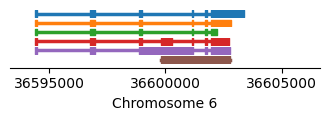

In [39]:
fig, ax = plt.subplots(nrows = 7, figsize=(4, .75), gridspec_kw={'height_ratios': ([1.5]*6)+[0.5], 
                                                                               'wspace': 0.3, 'hspace': 0.3})

xlim1 = int(rds['ebpmf_5']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_5']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000112081', colores = colores,
                         axes=ax[:6], xlim=xlim, lwidth=2.5, iso_order=['isoform_1', 'isoform_3', 'isoform_4', 'isoform_6', 'isoform_5', 'isoform_2'])


ax[6].spines['top'].set_visible(False)
ax[6].spines['right'].set_visible(False)
ax[6].spines['left'].set_visible(False)
ax[6].set_yticks([])
ax[6].set_xlim(xlim)
ax[6].set_xticks([36595000, 36600000, 36605000])
ax[6].set_xticklabels(['36595000', '36600000', '36605000'])
ax[6].tick_params(labelsize=10)
ax[6].set_xlabel('Chromosome 6', fontsize=10)


plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_10.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_10.png', bbox_inches='tight', dpi=500)

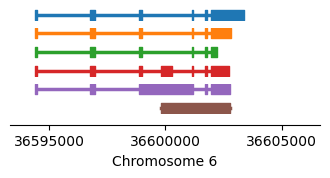

In [51]:
fig, ax = plt.subplots(nrows = 7, figsize=(4, 1.5), gridspec_kw={'height_ratios': ([1.5]*6)+[0.5], 
                                                                               'wspace': 0.3, 'hspace': 0.75})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000112081', colores = colores,
                         axes=ax, xlim=xlim, lwidth=2.5, iso_order=['isoform_1', 'isoform_3', 'isoform_4', 'isoform_6', 'isoform_5', 'isoform_2'])

ax[6].spines['top'].set_visible(False)
ax[6].spines['right'].set_visible(False)
ax[6].spines['left'].set_visible(False)
ax[6].set_yticks([])
ax[6].set_xlim(xlim)
ax[6].set_xticks([36595000, 36600000, 36605000])
ax[6].set_xticklabels(['36595000', '36600000', '36605000'])
ax[6].tick_params(labelsize=10)
ax[6].set_xlabel('Chromosome 6', fontsize=10)


plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_10.spacious.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_10.spacious.png', bbox_inches='tight', dpi=500)

In [44]:
EL = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/EL.bed.gz', sep='\t', index_col=3)
transcript_EL = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/transcript.merged_isoforms.EL.bed.gz', sep='\t', index_col=3)
samples = pd.read_csv('../code/config/samples.tsv', sep='\t', index_col=0)


In [45]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000112081.csv.gz', index_col=0)
counts.index = [x.split('.')[0] for x in counts.index]
samples = pd.read_csv('../code/config/samples.tsv', sep='\t', index_col=0)
def sum_every_ten_columns(dataframe):
    num_columns = dataframe.shape[1]
    new_columns = [dataframe.iloc[:, i:i+10].sum(axis=1) for i in range(0, num_columns, 10)]
    return pd.concat(new_columns, axis=1)

# Get the summed DataFrame
summed_df = sum_every_ten_columns(counts)


samples = samples.loc[samples.index.intersection(summed_df.index)]
# tissues = sorted(samples.loc[samples.index.intersection(counts.index)].tissue_id.unique())#.sort()#.sort_values()

tissues = sorted(['Brain_Anterior_cingulate_cortex_BA24',
 'Brain_Cortex',
 'Brain_Frontal_Cortex_BA9',
 'Brain_Putamen_basal_ganglia',
           'Skin_Not_Sun_Exposed_Suprapubic',
           'Liver',
 'Lung', 'Heart_Atrial_Appendage', 'Muscle_Skeletal','Whole_Blood'
          ])

from sklearn.preprocessing import scale

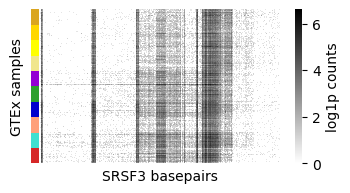

In [46]:


# Generate random data for the heatmaps

data_list = []

# Plotting the heatmaps on each axis using Seaborn
for i in range(10):
    
    data = summed_df.loc[samples.loc[samples.tissue_id == tissues[i]].index]
    
    data_list.append(data)
    
data = pd.concat(data_list, axis=0)

fig, axs = plt.subplots(1, 3, figsize=(4, 2), width_ratios = [0.1, 1, 40])

plt.subplots_adjust(wspace=0.01)


g = sns.heatmap(np.log1p(data), ax=axs[2], cmap='binary', cbar=True, cbar_kws={'label': 'log1p counts'})

# cbar = g.cbar_ax
# cbar.ax.tick_params(labelsize=10)

colors_list = ['goldenrod', 'gold', 'yellow', 'khaki', 'darkviolet', 'tab:green', 'mediumblue', 
            'lightsalmon', 'turquoise', 'tab:red']

axs[1].bar([1]*10, np.array(range(1, 11)[::-1])*100, color=colors_list)

# axs[0].imshow(colors_list)
axs[1].axis('off')  # Hide
axs[1].margins(0, 0)

# axs[0].axis('off')  # Hide
# axs[0].margins(-0.45, 0)


# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.01)

# Remove x and y ticks
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_xlabel('SRSF3 basepairs')#, fontsize=8)
axs[0].set_ylabel('GTEx samples')#, fontsize=8)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].spines['right'].set_visible(False)
axs[0].spines['left'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
# ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# plt.savefig('K99_plots/SRSF3_counts.png', dpi=500, bbox_inches='tight')


plt.savefig('../code/scratch_figures/figure1/SRSF3.counts_cbar.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/SRSF3.counts_cbar.png', bbox_inches='tight', dpi=500)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f724a1ebe20>>
Traceback (most recent call last):
  File "/project2/yangili1/cfbuenabadn/envs/rpython/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



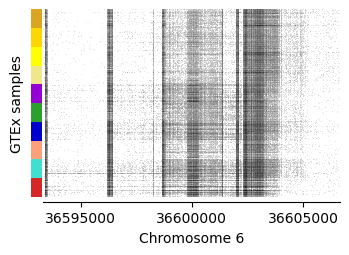

In [47]:


# Generate random data for the heatmaps

data_list = []

# Plotting the heatmaps on each axis using Seaborn
for i in range(10):
    
    data = summed_df.loc[samples.loc[samples.tissue_id == tissues[i]].index]
    
    data_list.append(data)
    
data = pd.concat(data_list, axis=0)

fig, axes = plt.subplots(2, 3, figsize=(4, 2.5), width_ratios = [0.1, 1.5, 40], height_ratios = [50,1])

plt.subplots_adjust(wspace=0.01, hspace=0.02)


g = sns.heatmap(np.log1p(data), ax=axes[0, 2], cmap='binary', cbar=False)

# cbar = g.cbar_ax
# cbar.ax.tick_params(labelsize=10)

colors_list = ['goldenrod', 'gold', 'yellow', 'khaki', 'darkviolet', 'tab:green', 'mediumblue', 
            'lightsalmon', 'turquoise', 'tab:red']

axes[0, 1].bar([1]*10, np.array(range(1, 11)[::-1])*100, color=colors_list)

# axs[0].imshow(colors_list)
axes[0, 1].axis('off')  # Hide
axes[0, 1].margins(0, 0)

# axs[0].axis('off')  # Hide
# axs[0].margins(-0.45, 0)


# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.01)

# Remove x and y ticks
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])
axes[0, 2].set_xticks([])
axes[0, 2].set_yticks([])
# axes[0, 2].set_xlabel('SRSF3 basepairs')#, fontsize=8)
axes[0, 0].set_ylabel('GTEx samples', fontsize=10)#, fontsize=8)
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])
axes[0, 0].spines['right'].set_visible(False)
axes[0, 0].spines['left'].set_visible(False)
axes[0, 0].spines['top'].set_visible(False)
axes[0, 0].spines['bottom'].set_visible(False)
# ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# plt.savefig('K99_plots/SRSF3_counts.png', dpi=500, bbox_inches='tight')


# plt.savefig('../code/scratch_figures/figure1/SRSF3.counts.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.counts.png', bbox_inches='tight', dpi=500)

axes[1, 2].spines['top'].set_visible(False)
axes[1, 2].spines['right'].set_visible(False)
axes[1, 2].spines['left'].set_visible(False)
axes[1, 2].set_yticks([])
axes[1, 2].set_xlim(xlim)
axes[1, 2].set_xticks([36595000, 36600000, 36605000])
axes[1, 2].set_xticklabels(['36595000', '36600000', '36605000'])
axes[1, 2].tick_params(labelsize=10)
axes[1, 2].set_xlabel('Chromosome 6', fontsize=10)


axes[1,0].axis('off')  # Hide
axes[1,0].margins(0, 0)
axes[1,1].axis('off')  # Hide
axes[1,1].margins(0, 0)

plt.savefig('../code/scratch_figures/figure1/SRSF3.counts.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/SRSF3.counts.png', bbox_inches='tight', dpi=500)

In [48]:
EL_to_plot = EL.loc[EL.gid == 'ENSG00000112081', sorted_samples].T 
# transcripts_to_plot
factor_order = [f'ENSG00000112081.{factor}' for factor in ['factor_1', 'factor_6', 'factor_7', 'factor_10', 'factor_3', 'factor_5',  
                                                           'factor_4', 'factor_9', 'factor_8', 'factor_2']]
EL_to_plot = EL_to_plot[factor_order]
EL_to_plot.columns = [f'ENSG00000112081.factor_{str(i)}' for i in range(1, 11)]

In [49]:
X = EL_to_plot.loc[[x for x in EL_to_plot.index if x in data.index]]


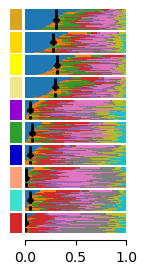

In [50]:
factor = transcript_EL.loc[transcript_EL.gid == 'ENSG00000112081', sample_slice.index].T.columns[1]
colors_list = ['goldenrod', 'gold', 'yellow', 'khaki', 'darkviolet', 'tab:green', 'mediumblue', 
            'lightsalmon', 'turquoise', 'tab:red']

colores = sns.color_palette("tab10")
# colores = [colores[0], colores[1], colores[3], colores[4], colores[5]]
factor_barplot_h(EL_to_plot, samples, colores,
              ['BA24', 'BC', 'BA9', 'BP', 'HRT', 'LIV', 'LUN', 'MS', 'SKN', 'WB'], sort_factor=True, one_row=True, figsize=(1.5, 3),
              tissue_colors = colors_list)

plt.savefig('../code/scratch_figures/figure1/SRSF3.hloadings_10.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/SRSF3.hloadings_10.png', bbox_inches='tight', dpi=500)

In [ ]:
transcripts_to_plot = transcript_EL.loc[transcript_EL.gid == 'ENSG00000112081', sorted_samples].T 
# transcripts_to_plot
iso_order=[f'ENSG00000112081.{iso}' for iso in ['isoform_1', 'isoform_3', 'isoform_4', 'isoform_6', 'isoform_5', 'isoform_2']]
transcripts_to_plot = transcripts_to_plot[iso_order]
transcripts_to_plot.columns = [f'ENSG00000112081.isoform_{str(i)}' for i in range(1, 7)]

In [ ]:
colors_list = ['goldenrod', 'gold', 'yellow', 'khaki', 'darkviolet', 'tab:green', 'mediumblue', 
            'lightsalmon', 'turquoise', 'tab:red']

colores = sns.color_palette("tab10")
# colores = [colores[0], colores[1], colores[3], colores[4], colores[5]]
factor_barplot_h(transcripts_to_plot, samples, colores,
              ['BA24', 'BC', 'BA9', 'BP', 'HRT', 'LIV', 'LUN', 'MS', 'SKN', 'WB'], sort_factor=True, one_row=True, figsize=(1.25, 3),
              tissue_colors = colors_list)

plt.savefig('../code/scratch_figures/figure1/SRSF3.hloadings_transcripts_10.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/SRSF3.hloadings_transcripts_10.png', bbox_inches='tight', dpi=500)

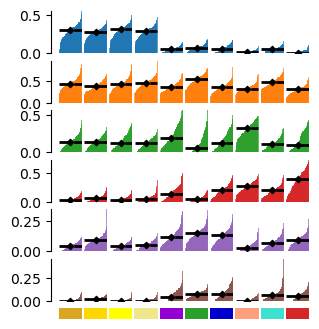

In [131]:
factor_barplot(transcripts_to_plot, samples, colores,
              ['BA24', 'BC', 'BA9', 'BP', 'HRT', 'LIV', 'LUN', 'MS', 'SKN', 'WB'], 
               tissue_colors = colors_list,
               sort_factor=True)

plt.savefig('../code/scratch_figures/figure1/SRSF3.loadings_transcripts_10.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/SRSF3.loadings_transcripts_10.png', bbox_inches='tight', dpi=500)

In [4]:
rds = load_ebpmf_gene('ENSG00000112081')

xlim1 = int(rds['ebpmf_5']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_5']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)


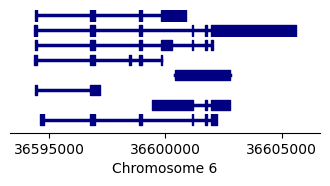

In [6]:
gencode_exons['chrom'] = gencode_exons['#chrom']
fig, ax = plt.subplots(nrows = 9, figsize=(4, 1.6), gridspec_kw={'height_ratios': ([1.5]*8)+[0.5], 
                                                                               'wspace': 0.3, 'hspace': 0.3})

xlim1 = int(rds['ebpmf_5']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_5']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

colores_gencode = ['navy']*300
plot_isoform_annotations(gencode_exons, 'ENSG00000112081', colores = colores_gencode,
                         axes=ax[:8], xlim=xlim, lwidth=2.5,)# iso_order=['isoform_1', 'isoform_3', 'isoform_4', 'isoform_6', 'isoform_5', 'isoform_2'])


ax[8].spines['top'].set_visible(False)
ax[8].spines['right'].set_visible(False)
ax[8].spines['left'].set_visible(False)
ax[8].set_yticks([])
ax[8].set_xlim(xlim)
ax[8].set_xticks([36595000, 36600000, 36605000])
ax[8].set_xticklabels(['36595000', '36600000', '36605000'])
ax[8].tick_params(labelsize=10)
ax[8].set_xlabel('Chromosome 6', fontsize=10)


plt.savefig('../code/scratch_figures/figure1/SRSF3.gencode.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/SRSF3.gencode.png', bbox_inches='tight', dpi=500)

In [ ]:
fig, ax = plt.subplots(nrows = 7, figsize=(4, 1.5), gridspec_kw={'height_ratios': ([1.5]*6)+[0.5], 
                                                                               'wspace': 0.3, 'hspace': 0.75})

xlim1 = int(rds['ebpmf_5']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_5']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000112081', colores = colores,
                         axes=ax, xlim=xlim, lwidth=2.5, iso_order=['isoform_1', 'isoform_3', 'isoform_4', 'isoform_6', 'isoform_5', 'isoform_2'])

ax[6].spines['top'].set_visible(False)
ax[6].spines['right'].set_visible(False)
ax[6].spines['left'].set_visible(False)
ax[6].set_yticks([])
ax[6].set_xlim(xlim)
ax[6].set_xticks([36595000, 36600000, 36605000])
ax[6].set_xticklabels(['36595000', '36600000', '36605000'])
ax[6].tick_params(labelsize=10)
ax[6].set_xlabel('Chromosome 6', fontsize=10)


plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_10.spacious.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_10.spacious.png', bbox_inches='tight', dpi=500)

In [13]:
len(gencode_exons.loc[gencode_exons.gene_id == 'ENSG00000112081'].transcript_id.unique())

8

In [79]:
rds = load_ebpmf_gene('ENSG00000112081')


In [80]:
EF = pd.DataFrame(rds['ebpmf_10']['train_fit']['EF_smooth'][1:-1,:])
EF.index = rds['ebpmf_10']['coords']
EF.columns = [f'factor{str(i+1)}' for i in range(EF.shape[1])]

EF = EF[['factor1', 'factor6', 'factor7', 'factor10', 'factor3', 'factor5',  'factor4', 
                                   'factor9', 'factor8', 'factor2']]

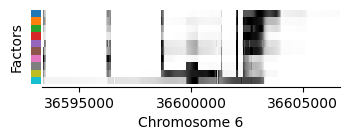

In [81]:
fig, axes = plt.subplots(2, 3, figsize=(4, 1), gridspec_kw={'wspace': 0.01, 'hspace': 0.02}, 
                             width_ratios = ([0.01, 1, 30]), height_ratios=[50,1])

sns.heatmap(np.array(np.minimum((EF/EF.quantile(0.99, axis=0)).T, 1)), cmap='binary', ax=axes[0, 2], vmin=0, cbar=False)
axes[0, 2].set_xticks([])
axes[0, 2].set_yticks([])

ax_ = axes[0,1]

colores = sns.color_palette("tab10")

for i, color in enumerate(colores[::-1]):
    ax_.barh([i], [1], color = color, height=1)

ax_.axis('off')  # Hide
ax_.margins(0, 0)
ax_.spines['top'].set_visible(False)
ax_.spines['bottom'].set_visible(False)
ax_.spines['right'].set_visible(False)
ax_.spines['left'].set_visible(False)
ax_.set_xticks([])
ax_.set_yticks([])

axes[1, 2].spines['top'].set_visible(False)
axes[1, 2].spines['right'].set_visible(False)
axes[1, 2].spines['left'].set_visible(False)
axes[1, 2].set_yticks([])
axes[1, 2].set_xlim(xlim)
axes[1, 2].set_xticks([36595000, 36600000, 36605000])
axes[1, 2].set_xticklabels(['36595000', '36600000', '36605000'])
axes[1, 2].tick_params(labelsize=10)
axes[1, 2].set_xlabel('Chromosome 6', fontsize=10)


axes[1,1].axis('off')  # Hide
axes[1,1].margins(0, 0)

axes[1,0].axis('off')  # Hide
axes[1,0].margins(0, 0)


axes[0,0].set_ylabel('Factors', fontsize=10)
axes[0,0].set_xticks([])
axes[0,0].set_yticks([])
axes[0,0].spines['right'].set_visible(False)
axes[0,0].spines['left'].set_visible(False)
axes[0,0].spines['top'].set_visible(False)
axes[0,0].spines['bottom'].set_visible(False)

plt.savefig('../code/scratch_figures/figure1/SRSF3.smoothed_factors_matrix.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/SRSF3.smoothed_factors_matrix.png', bbox_inches='tight', dpi=500)

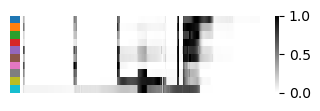

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(4, 1), gridspec_kw={'wspace': 0.01, 'hspace': 0.02}, 
                             width_ratios = ([1, 30]))

sns.heatmap(np.array(np.minimum((EF/EF.quantile(0.99, axis=0)).T, 1)), cmap='binary', ax=axes[1], vmin=0, cbar=True)
axes[1].set_xticks([])
axes[1].set_yticks([])

ax_ = axes[0]

colores = sns.color_palette("tab10")

for i, color in enumerate(colores[::-1]):
    ax_.barh([i], [1], color = color, height=1)

ax_.axis('off')  # Hide
ax_.margins(0, 0)
ax_.spines['top'].set_visible(False)
ax_.spines['bottom'].set_visible(False)
ax_.spines['right'].set_visible(False)
ax_.spines['left'].set_visible(False)
ax_.set_xticks([])
ax_.set_yticks([])


plt.savefig('../code/scratch_figures/figure1/SRSF3.smoothed_factors_matrix.cbar.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/SRSF3.smoothed_factors_matrix.cbar.png', bbox_inches='tight', dpi=500)

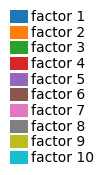

In [122]:
colores = sns.color_palette("tab10")


fig, axs = plt.subplots(10, 2, figsize=(0.5, 2))

colors_list = colores

tissue_list_names = [f'factor {str(k)}' for k in range(1, 11)]

for i, color in enumerate(colors_list):
    axs[i,0].bar([1], [1], color=color)
    axs[i,0].axis('off')  # Hide
    axs[i,0].margins(0, 0)

    axs[i,1].text(0, 0.15, tissue_list_names[i])#, c=color)
    axs[i,1].set_xticks([])
    axs[i,1].set_yticks([])
    axs[i,1].spines['right'].set_visible(False)
    axs[i,1].spines['left'].set_visible(False)
    axs[i,1].spines['top'].set_visible(False)
    axs[i,1].spines['bottom'].set_visible(False)

# axs[0].imshow(colors_list)

plt.savefig('../code/scratch_figures/figure1/factor.labels.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/factor.labels.png', bbox_inches='tight', dpi=500)

Text(0.5, 0, 'chromosome 19')

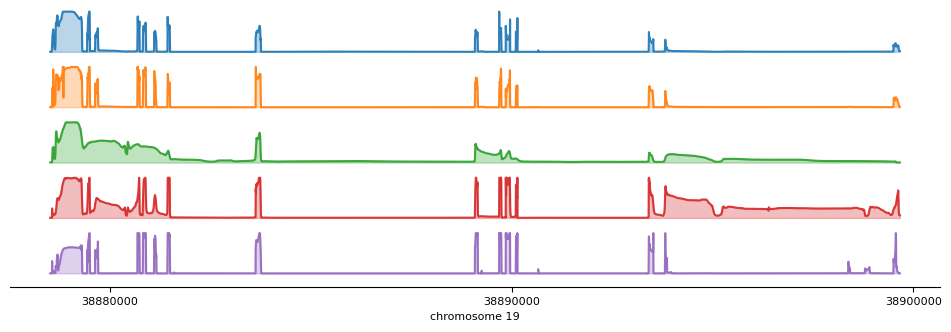

In [21]:
rds = load_ebpmf_gene('ENSG00000068903')
colores = sns.color_palette("tab10", 10)

fig, ax = plt.subplots(nrows = 6, figsize=(12, 3.6), gridspec_kw={'height_ratios': [1.5]*5 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.3})

xlim1 = int(rds['ebpmf_5']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_5']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)


plot_factors_wrapper(rds, 'ENSG00000068903', 'ebpmf_5', colores=colores, ax=ax[:5], xlim=xlim, lwidth=1, mute_y_axis=True, lm=True,
                    factor_list = ['factor1', 'factor3', 'factor4', 'factor2', 'factor5'])

ax[5].spines['top'].set_visible(False)
ax[5].spines['right'].set_visible(False)
ax[5].spines['left'].set_visible(False)
ax[5].set_yticks([])
ax[5].set_xlim(xlim)
ax[5].set_xticks([38880000, 38890000, 38900000])
ax[5].set_xticklabels(['38880000', '38890000', '38900000'])
ax[5].tick_params(labelsize=8)
ax[5].set_xlabel('chromosome 19', fontsize=8)

# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.png', bbox_inches='tight', dpi=500)

Text(0.5, 0, 'chromosome 19')

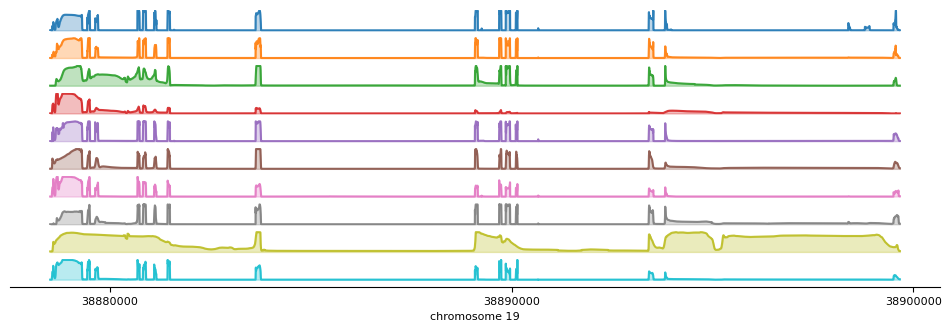

In [22]:
rds = load_ebpmf_gene('ENSG00000068903')
colores = sns.color_palette("tab10", 10)

fig, ax = plt.subplots(nrows = 11, figsize=(12, 3.6), gridspec_kw={'height_ratios': [1.5]*10 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.3})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)


plot_factors_wrapper(rds, 'ENSG00000068903', 'ebpmf_10', colores=colores, ax=ax[:10], xlim=xlim, lwidth=1, mute_y_axis=True, lm=True)

ax[10].spines['top'].set_visible(False)
ax[10].spines['right'].set_visible(False)
ax[10].spines['left'].set_visible(False)
ax[10].set_yticks([])
ax[10].set_xlim(xlim)
ax[10].set_xticks([38880000, 38890000, 38900000])
ax[10].set_xticklabels(['38880000', '38890000', '38900000'])
ax[10].tick_params(labelsize=8)
ax[10].set_xlabel('chromosome 19', fontsize=8)

# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.png', bbox_inches='tight', dpi=500)

Text(0.5, 0, 'chromosome 19')

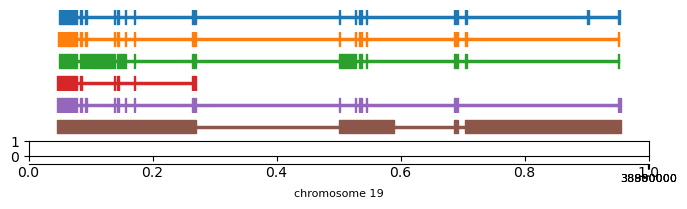

In [15]:
fig, ax = plt.subplots(nrows = 8, figsize=(8, 2), gridspec_kw={'height_ratios': [1.5]*7+[0.1], 
                                                                               'wspace': 0.3, 'hspace': 0.5})

rds = load_ebpmf_gene('ENSG00000068903')


xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000068903', colores = colores,
                         axes=ax[:7], xlim=xlim, lwidth=2.5)


ax[7].spines['top'].set_visible(False)
ax[7].spines['right'].set_visible(False)
ax[7].spines['left'].set_visible(False)
ax[7].set_yticks([])
# ax[5].set_xlim(xlim)
ax[7].set_xticks([38880000, 38890000, 38900000])
ax[7].set_xticklabels(['38880000', '38890000', '38900000'])
ax[7].tick_params(labelsize=8)
ax[7].set_xlabel('chromosome 19', fontsize=8)

Text(0.5, 0, 'chromosome 19')

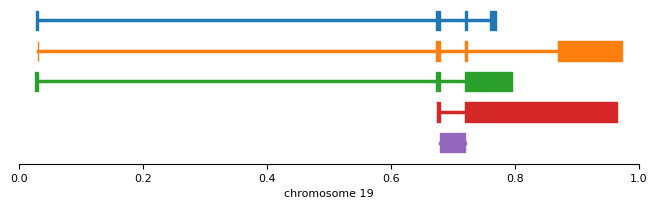

In [10]:
fig, ax = plt.subplots(nrows = 6, figsize=(8, 2), gridspec_kw={'height_ratios': [1.5]*5+[0.1], 
                                                                               'wspace': 0.3, 'hspace': 0.5})

rds = load_ebpmf_gene('ENSG00000100321')


xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000100321', colores = colores,
                         axes=ax[:5], xlim=xlim, lwidth=2.5)


ax[5].spines['top'].set_visible(False)
ax[5].spines['right'].set_visible(False)
ax[5].spines['left'].set_visible(False)
ax[5].set_yticks([])
# ax[5].set_xlim(xlim)
# ax[5].set_xticks([38880000, 38890000, 38900000])
# ax[5].set_xticklabels(['38880000', '38890000', '38900000'])
ax[5].tick_params(labelsize=8)
ax[5].set_xlabel('chromosome 19', fontsize=8)

IndexError: index 7 is out of bounds for axis 0 with size 7

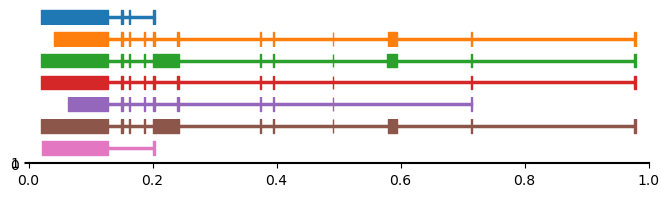

In [20]:
fig, ax = plt.subplots(nrows = 8, figsize=(8, 2), gridspec_kw={'height_ratios': [1.5]*7+[0.1], 
                                                                               'wspace': 0.3, 'hspace': 0.5})

rds = load_ebpmf_gene('ENSG00000106477')


xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000106477', colores = colores,
                         axes=ax[:7], xlim=xlim, lwidth=2.5)


ax[7].spines['top'].set_visible(False)
ax[7].spines['right'].set_visible(False)
ax[7].spines['left'].set_visible(False)
ax[7].set_yticks([])
# ax[5].set_xlim(xlim)
ax[7].set_xticks([38880000, 38890000, 38900000])
ax[7].set_xticklabels(['38880000', '38890000', '38900000'])
ax[7].tick_params(labelsize=8)
ax[7].set_xlabel('chromosome 19', fontsize=8)

In [4]:
rds = load_ebpmf_gene('ENSG00000100321')

junc_file = '/project2/mstephens/cfbuenabadn/gtex-stm/code/junctions.tab.gz'
coords = rds[f'ebpmf_10']['coords']
junctions_bed = get_junctions_bed(coords, junc_file, gene)
coords_all = list(rds['coords'])
coords = list(rds[f'ebpmf_10']['coords'])

In [5]:
isoforms = get_isoforms(rds[f'ebpmf_10']['train_fit']['EF_smooth'], junctions_bed, coords, coords_all, binary_fraction=0.5, 
                            correct_bias = False, print_gene = 'ENSG00000100321')

1
15
2
15
3
15
4
15
5
15
6
15
7
15
8
15
9
15
10
15


In [60]:
snmf_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/snmf_10/tables/snmf.merged_isoforms.exons.sorted.bed.gz'
snmf_exons = pd.read_csv(snmf_exons_bed, sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 
                                                 'transcript_id', 'strand', 'factors', 'exon_id'])

In [63]:
snmf_exons.loc[snmf_exons.gene_id == 'ENSG00000100321']

,chrom,start,end,gene_id,transcript_id,strand,factors,exon_id
510711,chr22,39349942,39350109,ENSG00000100321,ENSG00000100321.isoform_3,+,factor_7,exon_1
510712,chr22,39349969,39350109,ENSG00000100321,ENSG00000100321.isoform_1,+,factor_4,exon_1
510713,chr22,39350077,39350109,ENSG00000100321,ENSG00000100321.isoform_2,+,factor_1:factor_3:factor_2:factor_5:factor_8:f...,exon_1
510714,chr22,39374316,39374553,ENSG00000100321,ENSG00000100321.isoform_3,+,factor_7,exon_2
510715,chr22,39374316,39374553,ENSG00000100321,ENSG00000100321.isoform_2,+,factor_1:factor_3:factor_2:factor_5:factor_8:f...,exon_2
510716,chr22,39374316,39374553,ENSG00000100321,ENSG00000100321.isoform_1,+,factor_4,exon_2
510717,chr22,39374326,39374553,ENSG00000100321,ENSG00000100321.isoform_4,+,factor_9,exon_1
510718,chr22,39374556,39376073,ENSG00000100321,ENSG00000100321.isoform_5,+,factor_10,exon_1
510719,chr22,39376052,39378901,ENSG00000100321,ENSG00000100321.isoform_3,+,factor_7,exon_3
510720,chr22,39376052,39380615,ENSG00000100321,ENSG00000100321.isoform_4,+,factor_9,exon_2


In [ ]:
fig, ax = plt.subplots(nrows = 10, figsize=(8, 2), gridspec_kw={'height_ratios': [1.5]*9+[0.1], 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)
# ) - Summary
colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000112081', colores = colores,
                         axes=ax[:5], xlim=xlim, lwidth=2.5)


ax[9].spines['top'].set_visible(False)
ax[9].spines['right'].set_visible(False)
ax[9].spines['left'].set_visible(False)
ax[9].set_yticks([])
ax[9].set_xlim(xlim)
ax[9].set_xticks([38880000, 38890000, 38900000])
ax[9].set_xticklabels(['38880000', '38890000', '38900000'])
ax[9].tick_params(labelsize=8)
ax[9].set_xlabel('chromosome 19', fontsize=8)

In [1]:
fig, ax = plt.subplots(nrows = 5, figsize=(8, 1.8), gridspec_kw={'height_ratios': [1.5]*4+[0.1], 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000068903', colores = colores,
                         axes=ax[:4], xlim=xlim, lwidth=2.5)


ax[4].spines['top'].set_visible(False)
ax[4].spines['right'].set_visible(False)
ax[4].spines['left'].set_visible(False)
ax[4].set_yticks([])
ax[4].set_xlim(xlim)
ax[4].set_xticks([38880000, 38890000, 38900000])
ax[4].set_xticklabels(['38880000', '38890000', '38900000'])
ax[4].tick_params(labelsize=8)
ax[4].set_xlabel('chromosome 19', fontsize=8)

NameError: name 'plt' is not defined

In [29]:
EL = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/EL.bed.gz', sep='\t', index_col=3)

In [30]:
samples = pd.read_csv('../code/config/samples.tsv', sep='\t', index_col=0)

tissues = sorted(['Brain_Anterior_cingulate_cortex_BA24',
 'Brain_Cortex',
 'Brain_Frontal_Cortex_BA9',
 'Brain_Putamen_basal_ganglia',
           'Skin_Not_Sun_Exposed_Suprapubic',
           'Liver',
 'Lung', 'Heart_Atrial_Appendage', 'Muscle_Skeletal','Whole_Blood'
          ])

sorted_samples = []
for t in tissues:
    sorted_samples.extend(list(EL.columns.intersection(samples.loc[samples.tissue_id == t].index)))

colors_list = ['goldenrod', 'gold', 'yellow', 'khaki', 'darkviolet', 'tab:green', 'mediumblue', 
            'lightsalmon', 'turquoise', 'tab:red']

tissue_list_names = ['Brain Anterior cingulate cortex BA24',
 'Brain Cortex',
 'Brain Frontal Cortex BA9',
 'Brain Putamen basal ganglia',
 'Heart Atrial Appendage',
 'Liver',
 'Lung',
 'Muscle Skeletal',
 'Skin Not Sun Exposed Suprapubic',
 'Whole Blood']

sample_slice = samples.loc[sorted_samples]

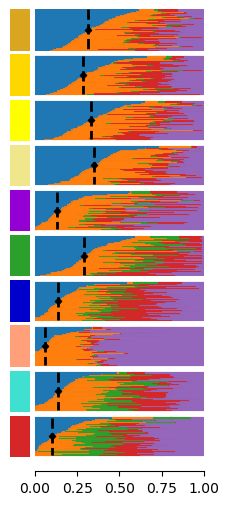

In [28]:
EL_to_plot = EL.loc[EL.gid == 'ENSG00000068903', sorted_samples].T 
# transcripts_to_plot
factor_order = [f'ENSG00000068903.{factor}' for factor in ['factor_1', 'factor_3', 'factor_4', 'factor_2', 'factor_5']]
EL_to_plot = EL_to_plot[factor_order]
EL_to_plot.columns = [f'ENSG00000068903.factor_{str(i)}' for i in range(1, 6)]

colors_list = ['goldenrod', 'gold', 'yellow', 'khaki', 'darkviolet', 'tab:green', 'mediumblue', 
            'lightsalmon', 'turquoise', 'tab:red']

colores = sns.color_palette("tab10")
# colores = [colores[0], colores[1], colores[3], colores[4], colores[5]]
factor_barplot_h(EL_to_plot, samples, colores,
              ['BA24', 'BC', 'BA9', 'BP', 'HRT', 'LIV', 'LUN', 'MS', 'SKN', 'WB'], sort_factor=True, one_row=True, figsize=(2.5, 6),
              tissue_colors = colors_list)

# plt.savefig('../code/scratch_figures/figure1/SRSF3.hloadings_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.hloadings_5.png', bbox_inches='tight', dpi=500)

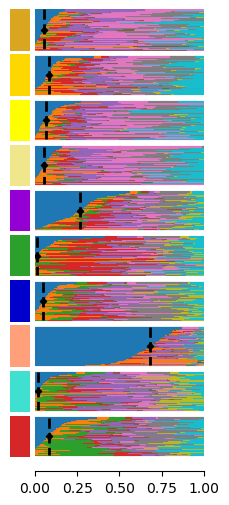

In [32]:
EL_to_plot = EL.loc[EL.gid == 'ENSG00000068903', sorted_samples].T 
# transcripts_to_plot
factor_order = [f'ENSG00000068903.{factor}' for factor in [f'factor_{str(x)}' for x in range(1, 11)]]
EL_to_plot = EL_to_plot[factor_order]
EL_to_plot.columns = [f'ENSG00000068903.factor_{str(i)}' for i in range(1, 11)]

colors_list = ['goldenrod', 'gold', 'yellow', 'khaki', 'darkviolet', 'tab:green', 'mediumblue', 
            'lightsalmon', 'turquoise', 'tab:red']

colores = sns.color_palette("tab10")
# colores = [colores[0], colores[1], colores[3], colores[4], colores[5]]
factor_barplot_h(EL_to_plot, samples, colores,
              ['BA24', 'BC', 'BA9', 'BP', 'HRT', 'LIV', 'LUN', 'MS', 'SKN', 'WB'], sort_factor=True, one_row=True, figsize=(2.5, 6),
              tissue_colors = colors_list)

# plt.savefig('../code/scratch_figures/figure1/SRSF3.hloadings_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.hloadings_5.png', bbox_inches='tight', dpi=500)

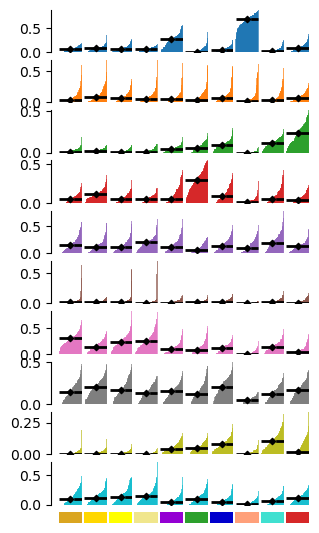

In [33]:
factor_barplot(EL_to_plot, samples, colores,
              ['BA24', 'BC', 'BA9', 'BP', 'HRT', 'LIV', 'LUN', 'MS', 'SKN', 'WB'], 
               tissue_colors = colors_list,
               sort_factor=True)

# plt.savefig('../code/scratch_figures/figure1/SRSF3.loadings_transcripts_10.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.loadings_transcripts_10.png', bbox_inches='tight', dpi=500)

In [1]:
import seaborn as sns

In [4]:
rds = load_ebpmf_gene('ENSG00000112081')
